<a href="https://colab.research.google.com/github/cfreeman22/data_mining_1_D209/blob/main/D209_data_mining1_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#inporting GridSearch and Pipeline from theesklearn library
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



# library to scaling the data
from sklearn.preprocessing import StandardScaler
# Library to split data
from sklearn.model_selection import train_test_split

# importing the kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier

#importing metric to test our model

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve, classification_report, 
)


In [2]:
#Customs funtions
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [3]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [4]:
#reading the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Reading the data from my google drive.
df = pd.read_csv('/content/drive/My Drive/churn_clean.csv')

## Data Preeparation steps

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

In [7]:
#target variable
df.Churn.value_counts()

No     7350
Yes    2650
Name: Churn, dtype: int64

In [8]:
df.Churn = df.Churn.map({'Yes':1 ,'No':0}).astype('int')
  

In [9]:
# Checking for duplicates
df.duplicated().sum()

0

In [10]:
#Checking for null
df.isnull().values.any()

False

In [11]:
# Dropping unnecessary columns
cols_to_drop =['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'Zip', 'Lat', 'Lng', 'TimeZone','City', 'State', 'County','Job','Population' ]

# Dropping unnecessary columns
df = df.drop(cols_to_drop, axis = 1)

# renaming the survey items columns
df = df.rename(columns={'Item1': 'TimelyResponse','Item2': 'TimelyFixes' , 'Item3': 'TimelyReplacements', 'Item4': 'Reliability',

                          'Item5': 'Options', 'Item6': 'RespectfulResponse', 'Item7': 'CourteousExchange', 'Item8': 'ActiveListening'})

# Checking to confirm if unnecessary columns were dropped and survey columns renamed appropriately

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  10000 non-null  object 
 1   Children              10000 non-null  int64  
 2   Age                   10000 non-null  int64  
 3   Income                10000 non-null  float64
 4   Marital               10000 non-null  object 
 5   Gender                10000 non-null  object 
 6   Churn                 10000 non-null  int64  
 7   Outage_sec_perweek    10000 non-null  float64
 8   Email                 10000 non-null  int64  
 9   Contacts              10000 non-null  int64  
 10  Yearly_equip_failure  10000 non-null  int64  
 11  Techie                10000 non-null  object 
 12  Contract              10000 non-null  object 
 13  Port_modem            10000 non-null  object 
 14  Tablet                10000 non-null  object 
 15  InternetService     

In [12]:
#extracting categorical variables
cat_vars =  df.select_dtypes(include=['object']).columns.to_list()
cat_vars

['Area',
 'Marital',
 'Gender',
 'Techie',
 'Contract',
 'Port_modem',
 'Tablet',
 'InternetService',
 'Phone',
 'Multiple',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod']

In [13]:
# Extracting numerical variables
for x in df.columns.to_list():
  if x not in cat_vars:
    print(x)

Children
Age
Income
Churn
Outage_sec_perweek
Email
Contacts
Yearly_equip_failure
Tenure
MonthlyCharge
Bandwidth_GB_Year
TimelyResponse
TimelyFixes
TimelyReplacements
Reliability
Options
RespectfulResponse
CourteousExchange
ActiveListening


In [14]:
# Changing object type to categories
for col in cat_vars:
   df[col] = df[col].astype('category')

In [15]:
# Renaming some categories for easy processing
df.Marital = df.Marital.cat.rename_categories({"Divorced":"Divorced","Widowed": "Widowed","Separated": "Separated", "Never Married": "NeverMarried", "Married":"Married"}) 
df.Contract = df.Contract.cat.rename_categories({"Month-to-month":"month_to_month","Two Year": "TwoYear","One year": "OneYear"})
df.InternetService = df.InternetService.cat.rename_categories({"Fiber Optic":"Fiber","DSL": "DSL","None": "NoService"})
df.PaymentMethod = df.PaymentMethod.cat.rename_categories({"Electronic Check":"ElectronicCheck","Mailed Check": "MailedCheck","Bank Transfer(automatic)": "BankTransfer",
                                                           "Credit Card (automatic)": "CreditCard"}) 


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Area                  10000 non-null  category
 1   Children              10000 non-null  int64   
 2   Age                   10000 non-null  int64   
 3   Income                10000 non-null  float64 
 4   Marital               10000 non-null  category
 5   Gender                10000 non-null  category
 6   Churn                 10000 non-null  int64   
 7   Outage_sec_perweek    10000 non-null  float64 
 8   Email                 10000 non-null  int64   
 9   Contacts              10000 non-null  int64   
 10  Yearly_equip_failure  10000 non-null  int64   
 11  Techie                10000 non-null  category
 12  Contract              10000 non-null  category
 13  Port_modem            10000 non-null  category
 14  Tablet                10000 non-null  category
 15  Int

In [17]:
## DROP EITHER TENURE OR BANDWIDTH from previous analysis these two features were highly correlated
#df = df.drop('Bandwidth_GB_Year', axis = 1)


## Saving the cleaned data set

In [18]:
 

#making a copy of the prepared dataset and extract a copy for submission

churn_df =  df.copy()

In [19]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Area                  10000 non-null  category
 1   Children              10000 non-null  int64   
 2   Age                   10000 non-null  int64   
 3   Income                10000 non-null  float64 
 4   Marital               10000 non-null  category
 5   Gender                10000 non-null  category
 6   Churn                 10000 non-null  int64   
 7   Outage_sec_perweek    10000 non-null  float64 
 8   Email                 10000 non-null  int64   
 9   Contacts              10000 non-null  int64   
 10  Yearly_equip_failure  10000 non-null  int64   
 11  Techie                10000 non-null  category
 12  Contract              10000 non-null  category
 13  Port_modem            10000 non-null  category
 14  Tablet                10000 non-null  category
 15  Int

In [20]:
# cleaned and prepared data
churn_df.to_csv('cleaned_prepared_churn.csv')

## Test Train Split and Scaling

In [21]:
X = churn_df
y = X.pop('Churn')
#Getting dummy variables for categorical columns
X = pd.get_dummies(X, drop_first=True)

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Children                       10000 non-null  int64  
 1   Age                            10000 non-null  int64  
 2   Income                         10000 non-null  float64
 3   Outage_sec_perweek             10000 non-null  float64
 4   Email                          10000 non-null  int64  
 5   Contacts                       10000 non-null  int64  
 6   Yearly_equip_failure           10000 non-null  int64  
 7   Tenure                         10000 non-null  float64
 8   MonthlyCharge                  10000 non-null  float64
 9   Bandwidth_GB_Year              10000 non-null  float64
 10  TimelyResponse                 10000 non-null  int64  
 11  TimelyFixes                    10000 non-null  int64  
 12  TimelyReplacements             10000 non-null  

In [23]:
#spliting the data
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                    test_size=0.3, random_state=42, stratify=y)

## Saving train and test sets into a csv

In [24]:
training_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

training_set.to_csv('training_set.csv', index=False)
test_set.to_csv('test_set.csv', index=False)

## Scaling the data

In [25]:
#scaling the data
scaler = StandardScaler()

In [26]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Using k value of 3 

In [27]:
knn = KNeighborsClassifier(n_neighbors= 3)

In [28]:
knn.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [29]:
knn_model_train_perf = model_performance_classification_sklearn_with_threshold(
    knn, scaled_X_train, y_train
)

print("Training performance:")
knn_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.903143,0.765499,0.853879,0.807277


In [30]:
knn_model_test_perf = model_performance_classification_sklearn_with_threshold(
    knn, scaled_X_test, y_test
)

print("Test set performance:")
knn_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.808,0.576101,0.657102,0.613941


## Finding k using the elbow method and model accuracy

In [31]:
#Finding the error rate for every value of k in range 1 - 25
test_error_rate = []

for k in range(1,25):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(scaled_X_train, y_train)
  y_pred_test = knn.predict(scaled_X_test)
  test_error = 1 - accuracy_score(y_test, y_pred_test)
  test_error_rate.append(test_error)


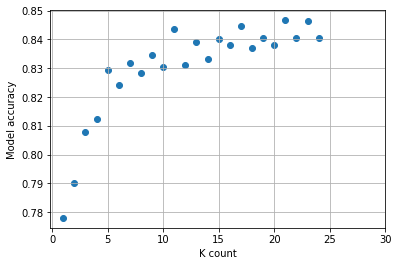

In [32]:
#Finding the accuracy for every value of k in range 1 - 25

scores = []
k_range = range(1,25)
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(scaled_X_train, y_train)
  scores.append(knn.score(scaled_X_test, y_test))


plt.figure()
plt.xlabel('K count')
plt.ylabel('Model accuracy')
plt.scatter(k_range, scores)
plt.grid()
plt.xticks([0,5,10,15,20,25,30])
plt.show()
 

Text(0.5, 0, 'K NEIGHBORS')

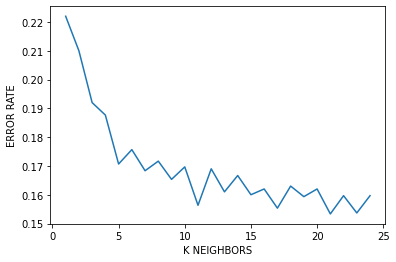

In [33]:
plt.plot(range(1,25), test_error_rate)
plt.ylabel("ERROR RATE")
plt.xlabel("K NEIGHBORS")

In [34]:
# USING k = 5
knn2 = KNeighborsClassifier(n_neighbors= 5)

knn2.fit(scaled_X_train, y_train)

KNeighborsClassifier()

In [35]:
#training set perfomance
knn_model_train_perf = model_performance_classification_sklearn_with_threshold(
    knn2, scaled_X_train, y_train
)

print("Training performance:")
knn_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.892,0.706739,0.860801,0.776199


In [36]:
# Test set performance
knn_model_test_perf = model_performance_classification_sklearn_with_threshold(
    knn2, scaled_X_test, y_test
)

print("Test set performance:")
knn_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.829333,0.597484,0.712144,0.649795


## Finding k with cross-validation using GridSearchCV 

In [37]:

# Pipeline for gridsearch and cross validation
#setting the scaller
scaler2 = StandardScaler()

#setting the knn model
knn3 = KNeighborsClassifier()

# our operations
operations = [('scaler2', scaler2), ('knn3', knn3)]



In [39]:
pipe = Pipeline(operations)

In [40]:
k_values = list(range(1,20))

In [41]:
param_grid = {'knn3__n_neighbors':k_values}

In [42]:
full_knn_cv_classifier = GridSearchCV(pipe,param_grid, cv =5, scoring='accuracy')

In [43]:
full_knn_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler2', StandardScaler()),
                                       ('knn3', KNeighborsClassifier())]),
             param_grid={'knn3__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19]},
             scoring='accuracy')

In [44]:
full_knn_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler2', StandardScaler()),
  ('knn3', KNeighborsClassifier(n_neighbors=13))],
 'verbose': False,
 'scaler2': StandardScaler(),
 'knn3': KNeighborsClassifier(n_neighbors=13),
 'scaler2__copy': True,
 'scaler2__with_mean': True,
 'scaler2__with_std': True,
 'knn3__algorithm': 'auto',
 'knn3__leaf_size': 30,
 'knn3__metric': 'minkowski',
 'knn3__metric_params': None,
 'knn3__n_jobs': None,
 'knn3__n_neighbors': 13,
 'knn3__p': 2,
 'knn3__weights': 'uniform'}

In [45]:
knn_model_train_perf = model_performance_classification_sklearn_with_threshold(
    full_knn_cv_classifier, X_train, y_train
)

print("Training performance:")
knn_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.872286,0.609164,0.8699,0.71655


In [46]:
knn_model_train_perf = model_performance_classification_sklearn_with_threshold(
    full_knn_cv_classifier, X_test, y_test
)

print("Test set performance:")
knn_model_train_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.839,0.530818,0.793233,0.636021


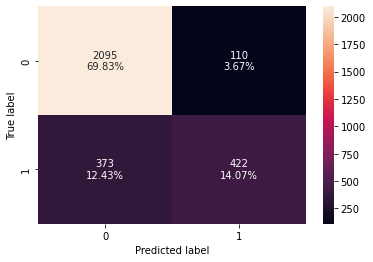

In [47]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(full_knn_cv_classifier, X_test, y_test)

In [48]:
pred_prob1 = knn.predict(scaled_X_test)
pred_prob2 = knn2.predict(scaled_X_test)
pred_prob3 = full_knn_cv_classifier.predict(X_test)


In [49]:
# Find fpr, tpr and threshold values
fpr1, tpr1, thresholds1 = roc_curve(y_test, knn.predict_proba(scaled_X_test)[:, 1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, knn2.predict_proba(scaled_X_test)[:, 1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(y_test, full_knn_cv_classifier.predict_proba(X_test)[:, 1], pos_label=1)
#ROC CURVE FOR TPR = FPR 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [50]:
# AUC scores for the three models
auc_score1 = roc_auc_score(y_test,knn.predict_proba(scaled_X_test)[:, 1])
auc_score2 = roc_auc_score(y_test,knn2.predict_proba(scaled_X_test)[:, 1])
auc_score3 = roc_auc_score(y_test,full_knn_cv_classifier.predict_proba(X_test)[:, 1])


print(auc_score1,auc_score2,auc_score3)

0.9197629743721388 0.8583199988590824 0.9050040645188893


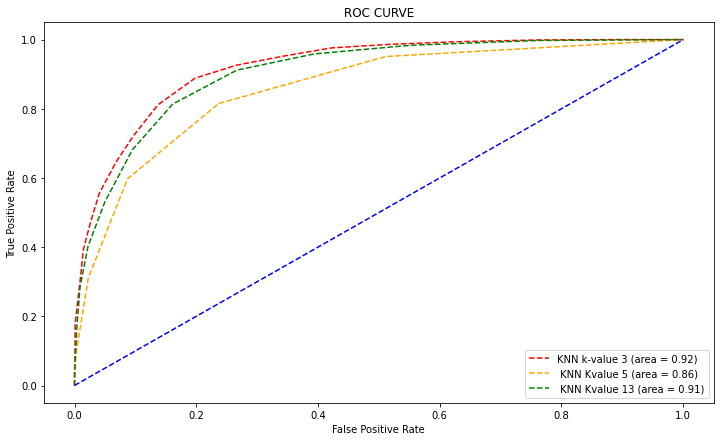

In [51]:
plt.figure(figsize=(12, 7))
plt.plot(fpr1, tpr1, linestyle= '--', color= 'red', label = 'KNN k-value 3 (area = %0.2f)' % auc_score1 )
plt.plot(fpr2, tpr2, linestyle= '--', color= 'orange', label = ' KNN Kvalue 5 (area = %0.2f)' % auc_score2 )
plt.plot(fpr3, tpr3, linestyle= '--', color= 'green', label = ' KNN Kvalue 13 (area = %0.2f)' % auc_score3 )
plt.plot(p_fpr, p_tpr, linestyle= '--', color= 'blue')
 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="best")
plt.show()